## Autor: Pablo Veloz
# Desafío - Regularización

## __Descripción__
- En esta ocasión utilizaremos datos de la composición química de muestras de vino.
- Nuestro propósito será tratar de predecir su calidad a partir de su composición química.
- Comience su estudio realizando un breve análisis exploratorio y descriptivo:
    * Identifique el tipo de datos de cada columna.
    * Identifique outliers univariados y multivariados. Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos.
    * Encuentre la cantidad de valores faltantes en cada columna.
    * Grafique la distribución empírica de cada atributo

## __Ejercicio 1:__ Preparación del Ambiente de Trabajo
* Importe las librerías básicas
* Importe los métodos asociados a regularización
* Importe la base de dato

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)
import cv_error as gfx
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [5]:
df = pd.read_csv('winequality-red.csv')
df.sample()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
534,10.0,0.48,0.24,2.7,0.102,13.0,32.0,1.0,3.28,0.56,10.0,6


## __Ejercicio 2:__ Análisis exploratorio
* Identifique el tipo de datos de cada columna.
* Identifique outliers univariados y multivariados. Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


# BoxPlots Univariados

In [7]:
def boxplot_num(dataframe,lista):
    var=lista
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.4,right = 2.0,bottom = -3.8)
    for i,n in enumerate(var):
        if n!="quality":
            plt.subplot(4,3,i+1)
            sns.boxplot(dataframe[n])
            plt.title("BoxPlot "+n,fontsize=20)
            sns.set_palette("bright")

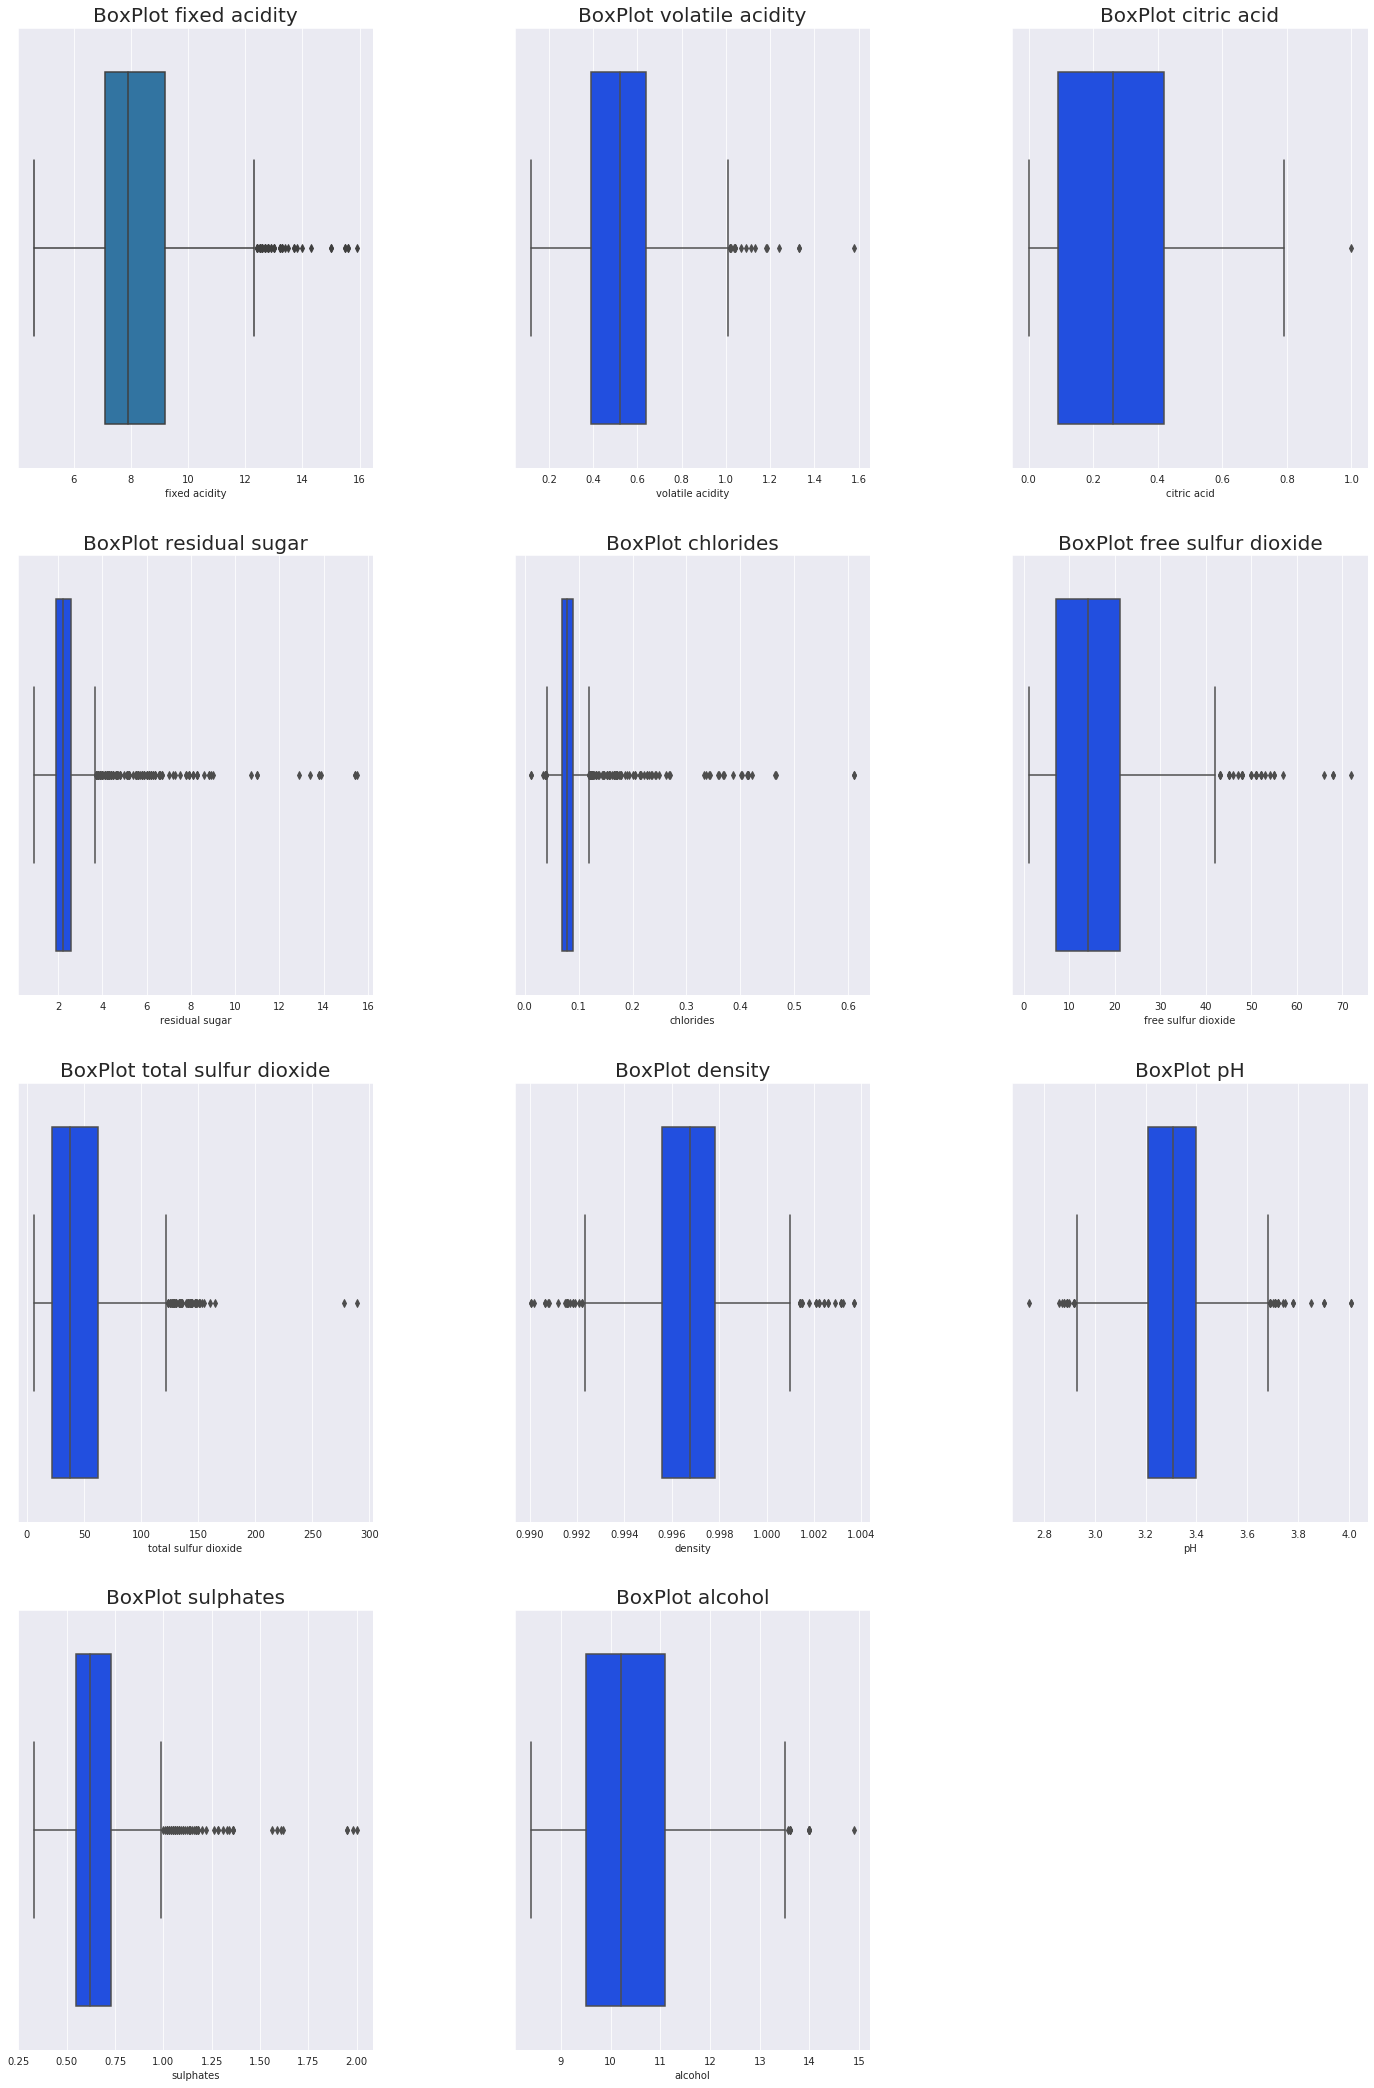

In [8]:
boxplot_num(df,df.columns)

- Las variables con menos outliers corresponden a: citric_acid, alcohol y quality.

# ScatterPlot Multivariados respecto de `Quality`

In [9]:
def scatter_num(dataframe,lista):
    var=lista
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.4,right = 2.0,bottom = -4.5)
    for i,n in enumerate(var):
        plt.subplot(4,3,i+1)
        sns.scatterplot(dataframe[n],dataframe["quality"])
        plt.title("Scatter Quality vs "+n,fontsize=20)
        sns.set_palette("bright")

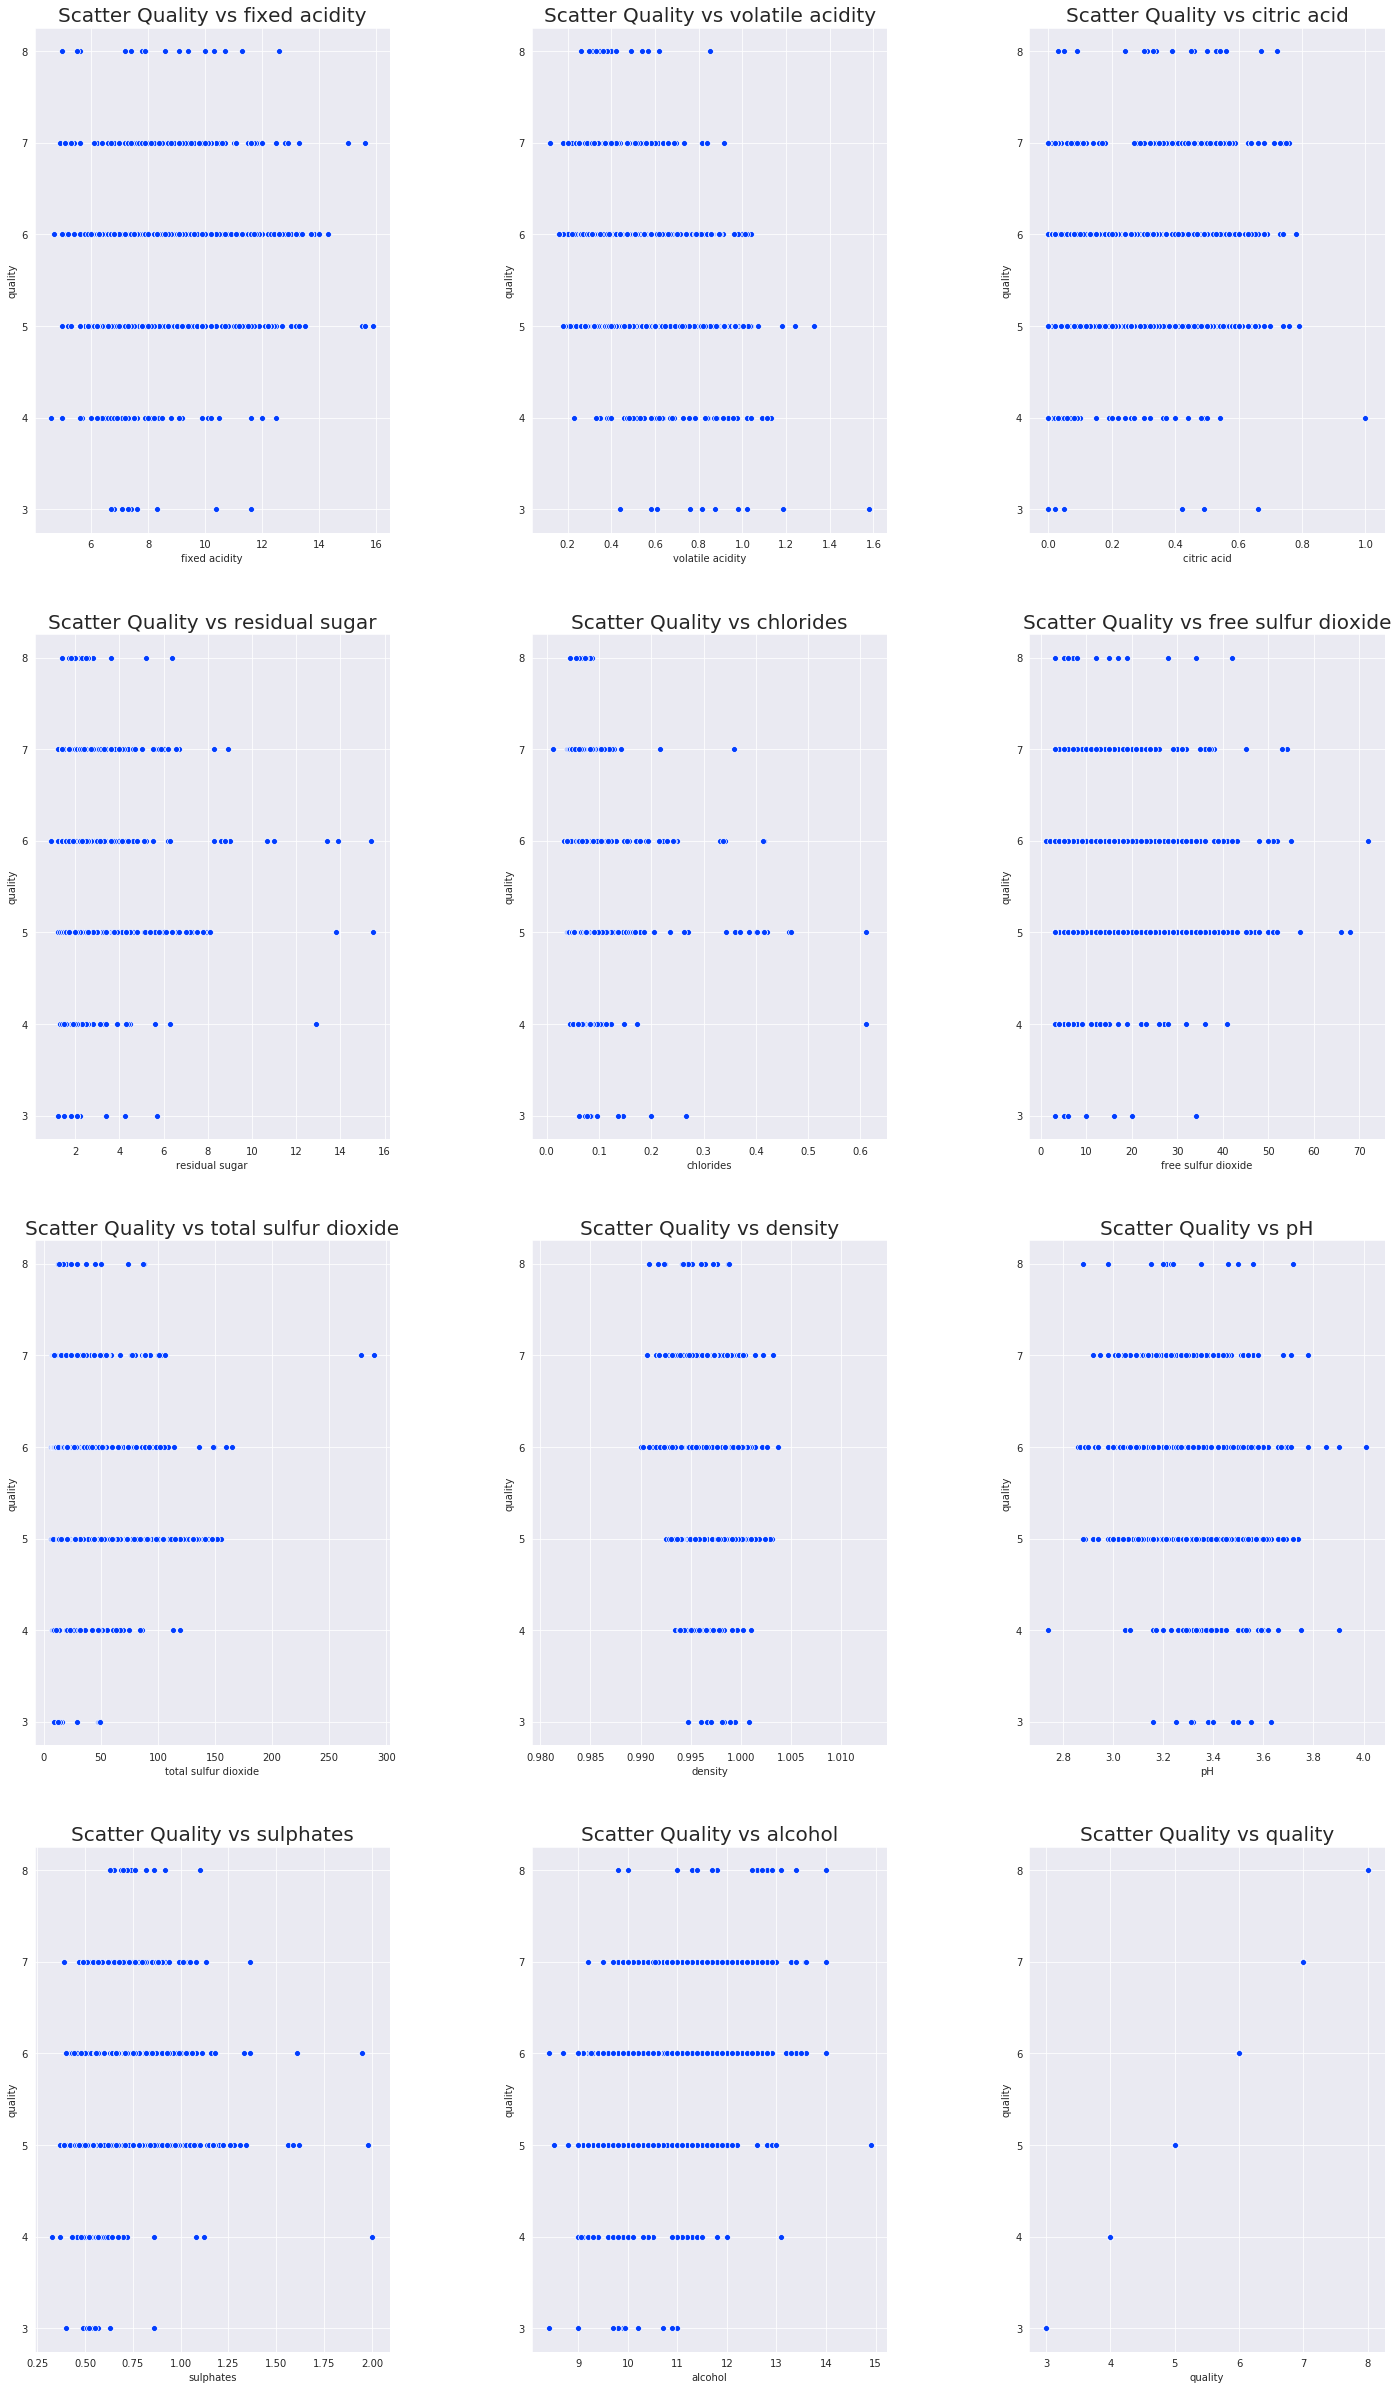

In [10]:
scatter_num(df,df.columns)

Destacan residual sugar y suphates como las variables que generan mayor cantidad de outliers respecto de `quality`.

In [11]:
#sns.distplot(df["quality"])
#plt.title("Quality",fontsize=20)
def hist_box(col):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode().get_values()[0]
    
    sns.boxplot(df[col], ax=ax_box)
    
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.axvline(mode, color='b', linestyle='-')

    sns.distplot(df[col], ax=ax_hist)
    ax_hist.axvline(mean, color='r', linestyle='--')
    ax_hist.axvline(median, color='g', linestyle='-')
    ax_hist.axvline(mode, color='b', linestyle='-')
    
    plt.legend({'Mean':mean,'Median':median,'Mode':mode})
    ax_box.set(xlabel=str(col)+": "+"Mean: "+str(round(mean,2))+" Median: "+str(round(median,2)))
    
    plt.show()

# Variable Objetivo `Quality`

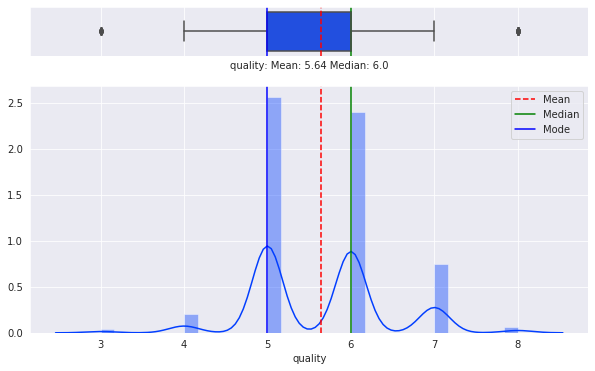

In [12]:
hist_box("quality")

- Se aprecia alta concentración de datos en quality 5 y 6.

In [13]:
def total_correlaciones(df, value=0.7):
    plt.figure(figsize=(15, 6))
    M = df.corr()
    value_corr = M[((M > value) & (M < 1) | (M < -value))
                  ].dropna(axis=0, how='all').dropna(axis=1, how='all')
    ax=sns.heatmap(value_corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 320, n=250),annot=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
    plt.title("Corralaciones Totales")

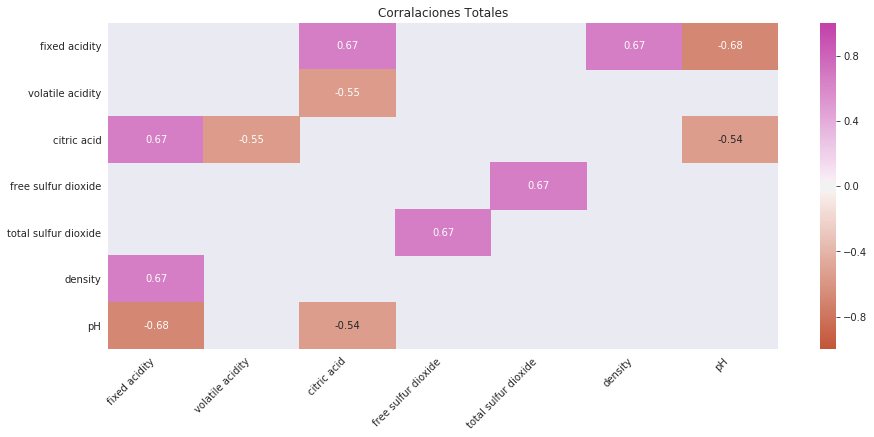

In [14]:
total_correlaciones(df,0.5)

- Ninguna de las variables, posee alta correlación con la variable objetvo `quality`
- A mayor acidity mayor citric acid.
- A mayor acidity menor pH.
- A mayor free sulfur dioxide mayor mayor total sulfur dioxide
- A mayor density mayor fixed acidity
- A mayor pH menor citric acid

## __Ejercicio 3:__ Regularización de modelos
* Genere tres modelos, correspondientes a RidgeCV, LassoCV y ElasticNetCV. 
* Para cadauno de ellos implemente los siguientes pasos:Entrene los modelos con 10 validaciones cruzadas.
* Extraiga los coeficientes estimados, el mejor valor alpha, MAE (median_absolute_error)y RMSE (mean_squared_error) asociado a cada modelo.
* En base a la información solicitada, responda lo siguiente:
    * ¿Qué modelo presenta un mejor desempeño en base a las métricas?
    * ¿Qué atributos mantienen un comportamiento similar a lo largo de cada modelo?

- ## __Sobre los métodos RidgeCV, LassoCV y ElasticNetCV__
    * Para implementar la búsqueda de hiperparámetros con validación cruzada, utilizaremos la clase `sklearn.linear_model.{RidgeCV, LassoCV, ElasticNetCV}`.
    * Por defecto, la clase necesita de una lista de valores alphas que representa el hiperparámetrode validación. Si no se define la lista, el método incorporará un array con valores por defecto.
    * Por defecto la clase tendrá una opción scoring que permitirá definir la métrica con la cual seevaluará el mejor hiperparámetro. Para el caso de un problema de regresión, si no se define, lamétrica será el error cuadrático promedio negativo (más alto es mejor).
    * Una vez entrenado el modelo, se puede reportar el mejor alpha conmodelo_entrenado.alpha_, el valor de los coeficientes con modelo_entrenado.coef_ y losvalores de la métrica de desempeño con modelo_entrenado.cv_values_

## Modelos y Train

In [15]:
X = df.iloc[:, :-1].columns
print(X)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


In [16]:
y_vec=df["quality"]
X_mat=df.iloc[:, :-1]

In [17]:
X_mat.shape

(1599, 11)

# Modelo RidgeCV

Valor del parámetro de regularización: 10.0




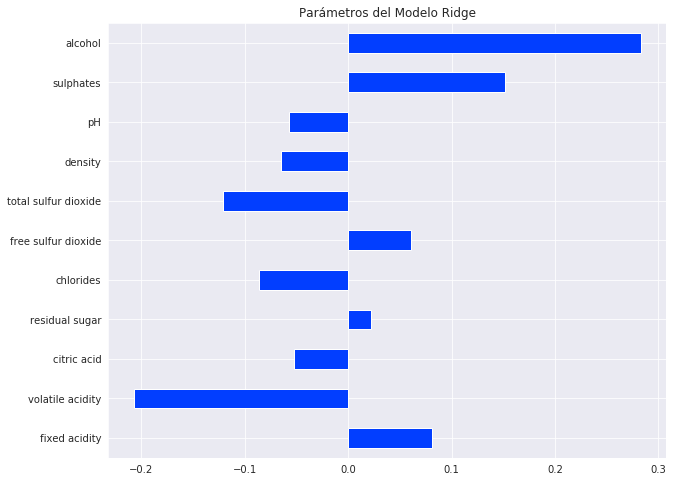

MAE: 0.3929
RMSE: 0.6436
R2_score: 0.3194


In [38]:
X_train,X_test,y_train,y_test=train_test_split(X_mat,y_vec,test_size=0.3,random_state=1)

std_scaler=StandardScaler().fit(X_train)
X_train=std_scaler.transform(X_train)
X_test=std_scaler.transform(X_test)


#alphas_ = np.logspace(-3, 1, base = 10)
ridge_cv = RidgeCV(cv = 10)
model_ridge = ridge_cv.fit(X_train, y_train)
#print(model_ridge.score(X_test,y_test))
def report_regularization(model, X_test, y_test,name_model):
    print('Valor del parámetro de regularización: {0}'.format(model.alpha_))
    #print('Coeficientes finales: \n{0}'.format(model.coef_))
    print('\n')
    plt.figure(figsize=(10,8))
    ft_importance=pd.Series(model.coef_, index= X_mat.columns)
    ft_importance.plot(kind='barh')
    plt.title("Parámetros del Modelo "+name_model)
    plt.show()
    y_hat =model.predict(X_test)
    print('MAE: {0}'.format(round(median_absolute_error(y_test,y_hat),4)))
    print('RMSE: {0}'.format(round(np.sqrt(mean_squared_error(y_test, y_hat)),4)))
    print('R2_score: {0}'.format(round(r2_score(y_test, y_hat),4)))
    
report_regularization(model_ridge, X_test, y_test,"Ridge")

- Si MAE < MSE 
    - Esperamos tener observaciones atípicas con subestimaciones. 
    - Nuestro modelo falla en identificar valores atípicos.
    - Esperamos tener una mayor concentración en valores altos de la distribución del error.

# Modelo LassoCV

Valor del parámetro de regularización: 0.011984644023242631




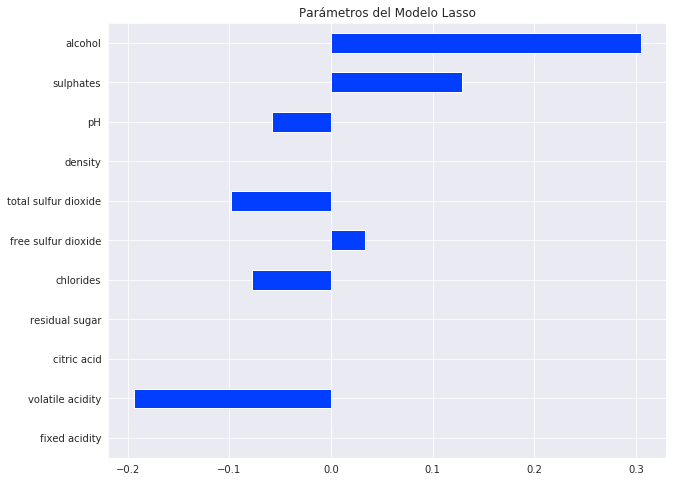

MAE: 0.3901
RMSE: 0.6399
R2_score: 0.3272


In [39]:
#alphas_ = np.logspace(0, -3, base = 10)
lasso_cv = LassoCV(cv=10)
model_lasso = lasso_cv.fit(X_train, y_train)
report_regularization(model_lasso, X_test, y_test,"Lasso")

# Modelo Elastic_CV

Valor del parámetro de regularización: 0.006366453314619957




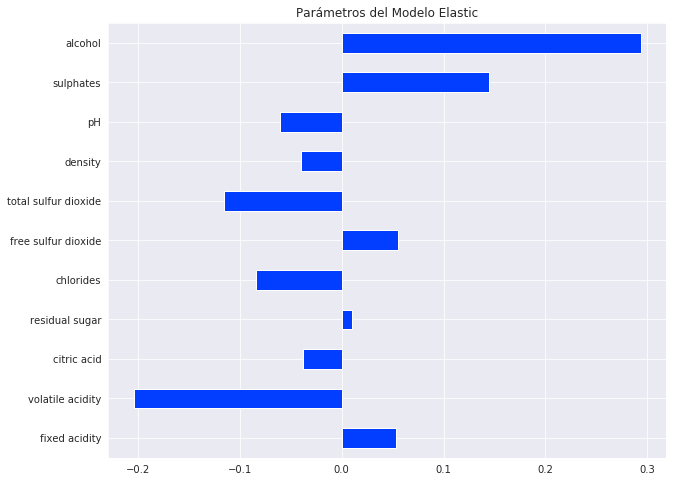

MAE: 0.391
RMSE: 0.6423
R2_score: 0.3222


In [40]:
#alphas_ = np.logspace(0, -3, base = 10)
elastic_cv = ElasticNetCV(cv = 10)
model_elastic = elastic_cv.fit(X_train, y_train)
report_regularization(model_elastic, X_test, y_test,"Elastic")

## Analisis:

Para todos los casos observados MAE < MSE

- Aunque las mejores métricas para comparar entre los modelos realizados fue __Lasso__

__Ridge:__ Incluye todas (o ninguna) de las características del modelo. Por lo tanto, la principal ventaja de la regresión de Ridge es la reducción del coeficiente y la reducción de la complejidad del modelo.

__Lasso__: junto con la reducción de los coeficientes, también realiza la selección de características. Como observamos, algunos de los coeficientes se vuelven exactamente cero, lo que es equivalente a la característica particular que se excluye del modelo.

__Elastic__: Genera una combinación entre los modelos mencionados anteriormente.

## Evaluando las Predicciones de los Modelos Regularizados 

# - __Ridge__

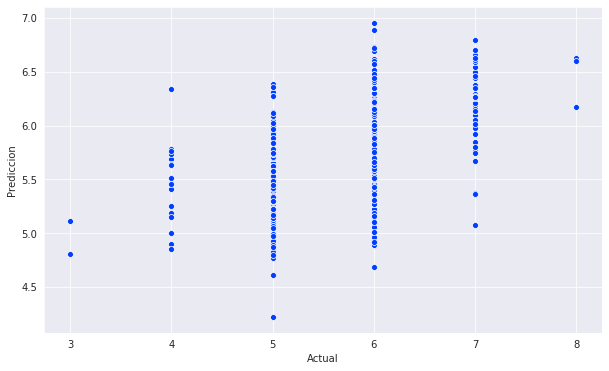

In [41]:
y_ridge_predict =model_ridge.predict(X_test)
df3 = pd.DataFrame({'Actual': y_test, 'Prediccion': y_ridge_predict})
sns.scatterplot(df3["Actual"],df3["Prediccion"])

# - __Lasso__

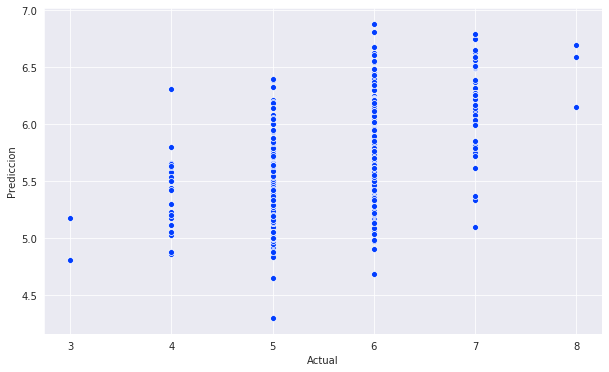

In [43]:
y_lasso_predict =model_lasso.predict(X_test)
df4 = pd.DataFrame({'Actual': y_test, 'Prediccion': y_lasso_predict})
sns.scatterplot(df4["Actual"],df4["Prediccion"])

# - __Elastic__

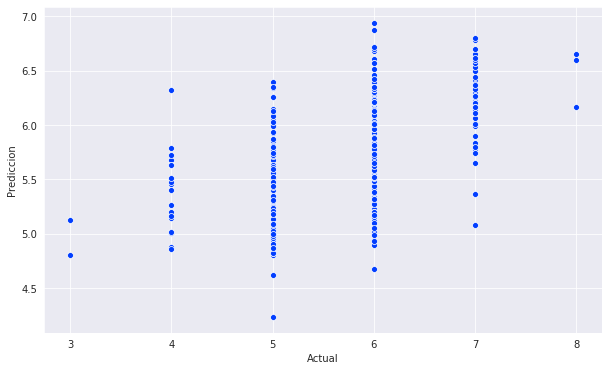

In [45]:
y_elastic_predict =model_elastic.predict(X_test)
df5 = pd.DataFrame({'Actual': y_test, 'Prediccion': y_elastic_predict})
sns.scatterplot(df5["Actual"],df5["Prediccion"])

- Se hará un promedio de las `Quality` que entrega cada __regularización__

In [47]:
lista=[3,4,5,6,7,8]
lista_ridge=[]
for i in df3["Actual"].unique():
    igual=df3[(df3["Actual"]==i)]
    promedio=round(igual["Prediccion"].mean(),3)
    #print(i,"Promedio Prediccion: ",round(igual["Prediccion"].mean(),3))
    lista_ridge.append(promedio)
lista_ridge=sorted(lista_ridge)

lista_lasso=[]
for i in df4["Actual"].unique():
    igual=df4[(df4["Actual"]==i)]
    promedio=round(igual["Prediccion"].mean(),3)
    #print(i,"Promedio Prediccion: ",round(igual["Prediccion"].mean(),3))
    lista_lasso.append(promedio)
lista_lasso=sorted(lista_lasso)

lista_elastic=[]
for i in df5["Actual"].unique():
    igual=df5[(df5["Actual"]==i)]
    promedio=round(igual["Prediccion"].mean(),3)
    #print(i,"Promedio Prediccion: ",round(igual["Prediccion"].mean(),3))
    lista_elastic.append(promedio)
lista_elastic=sorted(lista_elastic)

In [48]:
listado = list(zip(lista,lista_ridge,lista_lasso,lista_elastic))

In [49]:
tmp = pd.DataFrame(listado, columns = ['Quality', 'Ridge','Lasso','Elastic'])

- El promedio de las predicciones para cada `Quality` según la Regularización aplicada fue:

In [50]:
tmp

,Quality,Ridge,Lasso,Elastic
0,3,4.960,4.988,4.967
1,4,5.361,5.375,5.364
2,5,5.420,5.410,5.414
3,6,5.810,5.801,5.809
4,7,6.180,6.157,6.174
5,8,6.463,6.478,6.471


- Las mejores predicciones se generan en 5 y 6, que corresponden a las columnas con mayor cantidad de datos +.4 y -.2 de diferencia,aproximadamente ( Para todos los modelos de regularización)
